# <center> COVID-19 CHALLENGE 
# <center> TASK 5
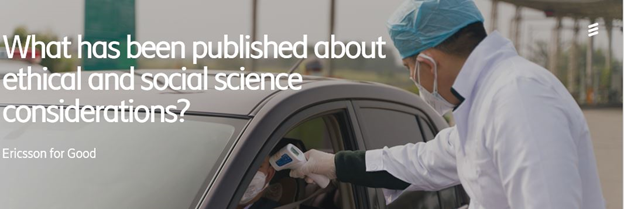

## THE CRITICAL CHALLENGE

How do healthcare communities, institutions, and nations confront the Novel Coronavirus Disease 2019 (COVID-19) pandemic while facing difficult and serious questions about their ethical responsibilities towards human societies and their governments?
    
## EXECUTIVE SUMMARY
* The Ericsson Task 5 team has developed a **Question-Answering Machine (intelligent search engine)**, using data science and data mining techniques, to assist the medical community in easily finding the most relevant answers to ethical and social considerations.

    
* This notebook brings together all available data sources together to answer the question of what has been published about ethical and social science considerations as it relates to COVID-19.

    
* The CORD-19 dataset represents the most extensive machine-readable coronavirus literature collection of more than 30,000 scientific articles available for data mining to date. However, the rapid increase in the volume and type of coronavirus literature makes it difficult for the medical community to keep up. 
  
    
* There is a growing urgency to develop text and data mining approaches to help the medical community to find answers to questions within, and connect insights across, this content in support of the ongoing COVID-19 response efforts worldwide.

    


## OVERVIEW VIDEO
This **5-minute video summary** lays out the challenge this work addresses and shows the user how to make rapid use of this specially created solution for Task 5.   It summarizes the approach, with screen capture annotations that make the code easy to read and reuse. Data visualizations that communicate the findings are explained.
>### https://web.microsoftstream.com/video/e14e3f49-982e-4c68-9cf3-b86913e13081
    

## FEATURES OF THIS NOTEBOOK

The rest of this notebook contains the following components:

* ### Methodology

* ### Pros and Cons

* ### Input/Output incl. Data Sources

* ### Code and Results

* ### Acknowledgement and Licensing

    Some parts of this notebook are excerpted from the notebooks below (Thanks to @xhlulu and @LuisBlanche): <br>
     > https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv
      
     > https://www.kaggle.com/luisblanche/cord-19-use-doc2vec-to-match-articles-to-tasks


## METHODOLOGY

The workflow in this figure illustrates the approach taken and includes both the design and operational phases. 
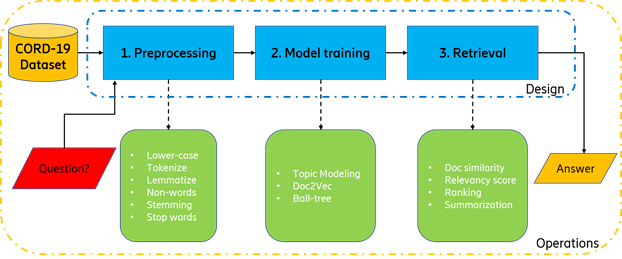

* In the **design phase**, the CORD-19 dataset is used to create the knowledge base, including the features extracted from its contents (abstracts and texts of the published articles), using pre-processing, model training and retrieval techniques. 


* The resulting **trained model** is then used to retrieve the most relevant answers (selected parts of the articles) to the questions entered by the user during the operational phase. 


The 3 main steps of the approach are as follows:


1.	**Preprocessing**: An important technique, data preprocessing transforms raw data into a format required for the modeling step. It results in retaining the most important keywords which helps to improve the efficiency of the retrieval process, as well as the quality of the results. Activities involved in this step are: <br>

        a.	Discard non-English articles (less than 5%) <br>
        b.	Changing words to lower case (Lower_case) <br>
        c.	Remove stop_words <br>
        d.	Lemmatization to group together inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma (dictionary form) <br>
        e.	Stemming to reduce inflected words to their word stem, base or root form—generally a written word form <br>


2.	**Model Training**: Data modeling in general is the process of producing a descriptive diagram of relationships between various types of information that are to be stored in a database. One of the goals of data modeling is to create the most efficient method of storing information while still providing for complete access and reporting. The modeling process as explained below is divided into multiple activities including topic modeling, Doc2Vec training and Ball-tree nearest neighbor research:
    
      a.	**Topic Modeling**:
      
      * **LDA topic modeling**: a type of statistical unsupervised modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is used to classify text in a document to a specific topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. We have applied LDA to select several topics with regard to the pertinent questions about our task. It can provide some insights to the user about the global overview of the entire dataset using the most frequent keywords in each topic.  
           
      * **Topic clustering**: topic clusters are a collection of interlinked articles or pages around one umbrella topic. They ultimately allow you to provide greater visibility for search engines to identify your content. A topic cluster starts with the main topic, which is also known as your “pillar” page.    
          
      * **Topic prediction and ranking**: this helps predict the similarity of the question to different topics that may help the user to either refine the question or limit the search space to find the most relevant answers using the dominant topic.

      b.	**Doc2Vec training**: Doc2Vec approach is employed to convert the text into feature vector, where it maintains the spatiotemporal relation of the sentences within the document. Since the abstract of each document is the most informative section, it is considered as the **training data**. It may help to improve the retrieval performance (less computational cost) and training a lighter model.

      c.	**Ball-tree**: This is the unsupervised version of KNN classification method, where it finds the nearest neighbors (vectors of articles) to the given question. The distance calculated using Ball-tree can be used as the relevancy score of retrieved articles to the questions.


3.	**Retrieval**: During the operation, we apply the trained model to extract a feature vector out of the question and calculate its distance to all the documents to obtain the text similarity. The distances will then be normalized as the relevancy scores and the articles will be ranked according to these scores. Finally, the _Gensim TextRank©_ method is used to summarize the abstract and the text of the retrieved documents in order to provide the most valuable sentences.


## PROS AND CONS OF THIS METHODOLOGY

Pros:
* In contrast to Word2Vec, the Doc2Vec model considers the matrix of paragraphs on top of the word windows during the training, where it helps to extract higher-level concepts than low-level features of Word2Vec.
* The model can extract low-dimensional features, yet meaningful from the multiple consecutive sentences.
* The model can be trained in the distributed fashion, where it can return the trained model in a reasonable time.

Cons:
* It may fail to extract appropriate features over the short sentences with limited number of words.
* It does not consider attention mechanism to apply more weights to the important combination of keywords and sentences.



## DATA SOURCE

1.	metadata.csv
2.	json_schema.txt
3.	biorxiv_medrxiv
4.	comm_use_subset
5.	COVID.DATA.LIC.AGMT.pdf
6.	custom_license
7.	metadata.readme
8.	noncomm_use_subset



In [ ]:
!pip install langdetect

In [ ]:
import os
import json
from pprint import pprint
from copy import deepcopy
from time import time
import random

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
import glob
from langdetect import detect
import pickle

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 

import gensim
from gensim.summarization import summarize
from gensim.models.doc2vec import Doc2Vec


import spacy
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import umap.umap_ as umap

import wordcloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

## Helper Functions 

These functions were defined to standardize the format of different information fields. 

* `format_name(author)`
* `format_affiliation(affiliation)`
* `format_authors(authors, with_affiliation=False)`
* `format_body(body_text)`
* `format_bib(bibs)`

In [ ]:
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])


def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    if authors==[]:
        return None
    
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    if body_text is None:
        return 'Not Provided'
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
        
    if len(body) <= 11:
        body += 'Not Provided'
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

## Class PaperReader

This class loads the papers and retreives the formatted information from the JSON format, and creates a DataFrame. To save on memory, only a subset of papers were used in this kernel. In the code below, you will have the option to remove a line mentioned with a comment, and use the whole set of data. 

In [ ]:
class PaperReader:
    def __init__(self, root_path):
        self.root_path = root_path
        self.filenames = glob.glob('{}/**/*.json'.format(root_path), recursive=True)
        self.filenames = self.filenames[:15000] #this line was added to save on memory, comment this line to load all the papers
        print(str(len(self.filenames))+' files were found')
        
    def load_files(self):
        raw_files = []

        for filename in tqdm(self.filenames):
            file = json.load(open(filename, 'rb'))
            raw_files.append(file)

        return raw_files
    
    def retrieve(self, file , field):
        try: 
            field = file[field]
        except KeyError:
            field = None
        return field
    
    def generate_clean_df(self):
        
        raw_files = self.load_files()
        cleaned_files = []

        for file in tqdm(raw_files):
            paper_id = self.retrieve(file , 'paper_id')
            title = self.retrieve(file['metadata'],'title')
            authors = self.retrieve(file['metadata'],'authors')
            abstract = self.retrieve(file, 'abstract')
            text = self.retrieve(file, 'body_text')
            
            features = [
                paper_id,
                title,
                format_authors(authors),
#                 format_authors(file['metadata']['authors'], 
#                                with_affiliation=True),
                format_body(abstract),
                format_body(text)
#                 format_bib(file['bib_entries']),
#                 file['metadata']['authors'],
#                 file['bib_entries']    for now we can comment these parts as we do not need the bibliography or affiliation 
                                        # so we can speed up the process. If you wish to include these fields make sure to add 
                                        # the correlated column name
            ]

            cleaned_files.append(features)

        col_names = ['paper_id', 'title' , 'authors', 
                    'abstract', 'text', 
                     ]

        clean_df = pd.DataFrame(cleaned_files, columns=col_names)
        clean_df.head()

        return clean_df

## Load Files

In [ ]:

root_path = '/kaggle/input'
# all_file_path = glob.glob('{}/**/*.json'.format(root_path), recursive=True)
# print(str(len(all_file_path))+' papers were found')

In [ ]:
PR = PaperReader(root_path)

In [ ]:
papers_df = PR.generate_clean_df()

## Cleaning the Data

The class *preprocessor* contains functions for preprocessing steps. 

In [ ]:
papers_df.info()

In [ ]:
class Preprocessor:
    
    def __init__(self, df):
        self.df = df
        self.text = df['text']
        self.abstract = df['abstract']
        
    def drop_duplicate(self):
        
        self.df.drop_duplicates(['abstract', 'text'], inplace = True)
    
    def dropna(self):
        
        self.df.dropna(inplace = True)
    
    def lower_case(self):
        
        self.df['text'] = self.df['text'].str.lower()
        self.df['abstract'] = self.df['abstract'].str.lower()
        #self.df['title'] = self.df['title'].str.lower()
        
        return self.df
        
        
    def filter_language(self , language = 'en'):
        
        def detect_language(text):
        
            portion=text[1000:2000]
            try:
                lang=detect(portion)
            except Exception:
                lang=None

            return lang

        self.df['lang'] = self.df['text'].apply(detect_language)
        self.df = self.df[self.df['lang'] == language]  
        
           
        
        
    def clean_string(self):
        
        def cleaner(text_col):
        
            #remove newline characters
#             clean_text = text_col.str.replace('\n', ' ')
            #remove strings with length <= 2
            clean_text =text_col.str.replace(r'\b\w{1,2}\b', '', regex=True)
    
            #separate words having dashline such as non-vegeterian --> non vegeterian
            clean_text = clean_text.str.replace('-', ' ')
            #remove punctuations and digits
#           clean_text = clean_text.str.replace(r'[^A-Za-z\s]', '', regex=True)
             
            #remove web links
            clean_text = clean_text.str.replace(r'(http|https)[\w\d]+\b','')
            clean_text = clean_text.str.replace(r'www.[\w\d]+.[\w\d]+','')
            #remove refrences
            clean_text = clean_text.str.replace(r'\[[\d ]+\]','')
            #remove digits
            clean_text = clean_text.str.replace(r'\d','')

            return clean_text
        
        self.df['text'] = cleaner(self.df['text'])
        self.df['abstract'] = cleaner(self.df['abstract'])
    
    def get_df(self):
        
        return self.df



In [ ]:
PP = Preprocessor(papers_df)

PP.dropna()
PP.drop_duplicate()
PP.filter_language()
PP.clean_string()
PP.lower_case()

preprocessed_df = PP.get_df()

We can save this data.

In [ ]:
#preprocessed_df.to_csv('/kaggle/clean_dataset/preprocessed_data.csv', index=False)

## Other processing steps

Load the cleaned dataset and apply processing steps.
Steps in processing the text:

- Tokenization
- Removing the stopwords
- Lemmatization

In [ ]:
#preprocessed_df = pd.read_csv('clean_dataset/preprocessed_data.csv')

Some words appear repetitively in the papers, but they are not informative about the topic, such as *doi*. These words were added to the customized stopwords set.

In [ ]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'introduction', 'section', 'abstract', 'summary',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'al'
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si','also', 'too',
    'que', 'qui', 'le', 'la', 'les', 'un', 'une', 'si','de', 'des', 'est', 'sont', 'plus', 'dans', 'par', 'ici',
    'para', 'por', 'lo', 'sera', 'viru', 'caso', 'entre', 'avec', 'sur', 'ont', 'pour', 'pa', 'ce', 'ca', 'ces', 'cehz', 'son', 'moi', 'toi'
]

stop_words = list(stopwords.words('english')) 
stop_words = stop_words + customize_stop_words 

**The following cell will take some time to run**

In [ ]:
def lemmatizer(text):
    global i
    # Lemmatize every word.
    # Init the Wordnet Lemmatizer
    tokens = word_tokenize(text)
    WNL = WordNetLemmatizer()
    return ' '.join([WNL.lemmatize(y) for y in tokens if y not in stop_words])

lemmas = preprocessed_df['text'].apply(lemmatizer)


In [ ]:
#lemmas.to_csv('clean_dataset/tokens.csv', index=False)

## Topic Modelling

Transform 1D DataFrame into 1D list where each index is an article (instance), so that we can work with words from each instance:

In [ ]:
#lemmas = pd.read_csv('clean_dataset/tokens.csv')

In [ ]:
lemmas = lemmas.tolist()
#tokens = [doc.split(" ") for doc in lemmas]     # uncomment only if you need the tokens

## LDA Topic Modeling

Define the parameters for countvectorizer. Use tf (raw term count) features for LDA. <br>
Set number of topics equivalent to the number of ethics-related questions.

In [ ]:
n_samples = len(lemmas) 
n_features = 4000
n_topics = 9
n_top_words = 50

In [ ]:
class lda_tools:
    
    def __init__(self , text_list , n_topics = None):
        self.text_list = text_list
        self.words = [doc.split(" ") for doc in text_list]
        self.tf = None
        self.tf_vec = None
        self.lda = None
        self.tf_feature_names = None
        self.lda_out_vec = None
        self.n_topics = n_topics
        self.tsne_embedding = None
    
    
    def count_vectorizer(self , max_df=0.95, min_df=2, max_features = 4000):
        count_vectorizer = CountVectorizer(max_df = max_df, min_df = min_df , max_features = max_features)
        t0 = time()
        self.tf = count_vectorizer.fit(self.text_list)
        self.tf_vec = count_vectorizer.transform(self.text_list)
        self.tf_feature_names = count_vectorizer.get_feature_names()
        print("Extracting tf features for LDA done in %0.3fs." % (time() - t0))
        
        return self.tf_vec
        
        
    def lda_model(self,  n_components= 15, max_iter=5, learning_method='online', learning_offset = 50):
        self.n_topics = n_components
        self.lda = LatentDirichletAllocation(n_components = n_components, max_iter = max_iter, learning_method = learning_method , learning_offset = learning_offset , random_state=0)
        t0 = time()
        self.lda.fit(self.tf_vec)
        print("Fitting LDA models with tf features, "
        "n_samples=%d and n_features=%d done in %0.3fs." % (n_samples, n_features, time() - t0))
        
        return self.lda
    
    def lda_out(self):
        if self.lda_out_vec is not None:
            return self.lda_out_vec
        else:
            model = self.lda
            tf_vec = self.tf_vec
            self.lda_out_vec = model.transform(tf_vec)

        
        return self.lda_out_vec

    def word_cloud_top_words(self, n_top_words = 15 , number_of_column = 3):
        model = self.lda
        feature_names = self.tf_feature_names
        num_topics=model.components_.shape[0]
        f, axarr = plt.subplots(int(np.ceil(num_topics/number_of_column)),number_of_column,figsize=(16, 16))
        Dict={}
        for topic_idx, topic in enumerate(model.components_):
            for i in topic.argsort()[:-n_top_words - 1:-1]:
                Dict[feature_names[i]] = topic[i]
            cloud = wordcloud.WordCloud(width=900, height=500,background_color='white').generate_from_frequencies(Dict)
            x=int(np.floor(topic_idx/number_of_column))
            r=topic_idx%number_of_column
            axarr[x,r].imshow(cloud)
            axarr[x,r].axis('off')
            topic_idx=topic_idx+1
            axarr[x,r].set_title("Topic %d " % topic_idx)
            Dict={}

    def print_top_words(self, n_top_words = 15):
        feature_names = self.tf_feature_names
        model = self.lda
        for topic_idx, topic in enumerate(model.components_):
            message = "Topic #%d: " % topic_idx
            message += " ".join([feature_names[i]
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message +"\n\n")

            
    def get_tSNE_embedding(self, n_components = 2):
        if self.tsne_embedding is None:
            lda_out = self.lda_out()
            X_embedded = TSNE(n_components = n_components).fit_transform(lda_out)
            self.tsne_embedding = X_embedded
        else:
            X_embedded = self.tsne_embedding
        return X_embedded 
    
    def get_y(self):
        lda_out = self.lda_out()
        y_pred = np.argmax(lda_out, axis=1)
        return y_pred
    
    def tSNE_plot(self, n_components = 2):
        X_embedded = self.get_tSNE_embedding(n_components = n_components)
        y_pred = self.get_y()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        # colors
        scatter=plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_pred , cmap="Paired", s=50, alpha=1)
        plt.title("t-SNE plot related to Non-negative Matrix Factorization on Covid-19 Articles")
        
    #Silhouette refers to a method of interpretation and validation of consistency within clusters of data.
    def calculate_silhouette(self):
        X_embedded = self.get_tSNE_embedding(n_components = 2)
        y_pred = self.get_y()
        silhouette_score = metrics.silhouette_score(X_embedded, y_pred, metric='euclidean')
        print ("Silhouette_score: ")
        print (silhouette_score)
        
    def topic_probability_scores(self , lda_out_vec = None, num_docs = None):
        if num_docs is None:
            num_docs = len(self.words)
        if lda_out_vec is None:
            lda_out_vec = np.matrix(self.lda_out())
            
        lda = self.lda
        if not self.n_topics:
            self.n_topics = 15
        n_components = self.n_topics
        # column names
        topicnames = ["Topic" + str(i) for i in range(n_components)]

        # index names
        docnames = ["Doc" + str(i) for i in range(num_docs)]

        # Make the pandas dataframe
        df_document_topic = pd.DataFrame(np.round(lda_out_vec, 2), columns=topicnames, index=docnames)

        # Get dominant topic for each document
        dominant_topic = np.argmax(df_document_topic.values, axis=1)
        df_document_topic['dominant_topic'] = dominant_topic

        return df_document_topic
        
    def get_topic_keywords(self):
        # Topic-Keyword Matrix
        df_topic_keywords = pd.DataFrame(self.lda.components_)
        
        
        # Assign Column and Index
        df_topic_keywords.columns = self.tf_feature_names
        df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
        
        return df_topic_keywords
    
    # Show top n keywords for each topic
    def show_topics(self, n_words=20):
        feature_names = self.tf_feature_names
        model = self.lda
        keywords = np.array(feature_names)
        topic_keywords = []
        
        for topic_weights in model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        
        df_topic_keywords = pd.DataFrame(topic_keywords)
        df_topic_keywords.columns = ['Keyword '+str(i) for i in range(df_topic_keywords.shape[1])]
        df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
        
        return topic_keywords  


    def get_topic_distribution(self):
        df_document_topics = self.topic_probability_scores()
        df_topic_distribution = df_document_topics['dominant_topic'].value_counts().reset_index(name="Num Documents")
        df_topic_distribution.columns = ['Topic Num', 'Num Documents']
        return df_topic_distribution
    
    def predict_topic(self,new_text_list):
        
        num_new_text = len(new_text_list)
        test_tf_vec = self.tf.transform(new_text_list)
        test_lda_out = self.lda.transform(test_tf_vec) 
        df_topic_keywords = self.get_topic_keywords()
        #topics = df_topic_keywords.iloc[np.argmax(test_lda_out), :].values.tolist()
        
        topic_probability_score = self.topic_probability_scores(test_lda_out, num_new_text)
        
        return  test_lda_out , topic_probability_score
    
    def get_similar_documents(self, df, lda_out_test, top_n_similar, verbose=False):
        
        lda_out_vec = self.lda_out()
        dists = euclidean_distances(lda_out_test.reshape(1, -1), self.lda_out_vec)[0]
        
        try:
            doc_ids = np.argsort(dists)[:top_n_similar]
            
        except Exception:
            doc_ids = np.argsort(dists)
            
        print('doc_ids = \n{}'.format(doc_ids))

        return doc_ids, df.iloc[doc_ids, :]
    

In [ ]:
LT = lda_tools(lemmas)
LT.count_vectorizer(max_df=0.95, min_df=2, max_features = 6000)

**It takes some time to run the lda_model **

In [ ]:
LT.lda_model(n_components= n_topics, max_iter=5, learning_method='online', learning_offset = 50)

We can save the LDA model to use later with the visualization tools, as it takes time to retrain the model. 

In [ ]:
# filehandler = open('clean_dataset/lda_object.txt', 'wb') 
# pickle.dump(LT, filehandler)

for loading an existing LT object for the following sections, run the cell below: (make sure you have run the cell containing the class first)

In [ ]:
# filehandler = open('clean_dataset/lda_object.txt', 'rb') 
# LT = pickle.load(filehandler)

You can continue analysing the LDA results. 

In [ ]:
LT.print_top_words(n_top_words = 15)

In [ ]:
LT.word_cloud_top_words(n_top_words = 30)

In [ ]:
LT.tSNE_plot(n_components = 2)

The silhouette metrics is a measure of performance of the clustering. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If the score is near 0, it means either we have too many clusters or too few of them. 

In [ ]:
LT.calculate_silhouette()

In [ ]:
df_document_topics_probability = LT.topic_probability_scores()
df_document_topics_probability

In [ ]:
topics_keywords_df = LT.get_topic_keywords()
topics_keywords_df.head(n_topics)

In [ ]:
topic_distribution = LT.get_topic_distribution()
ax = topic_distribution.plot.bar(x='Topic Num', y='Num Documents', colormap='Paired')
ax.set_ylabel('Num Documents')

To get the topic probability for a new document:

In [ ]:
new_text_list = lemmas[15:20]

# or  a question = ['how we can provide urgent help poor countries to have access to sustainable education system while the virus is spraeding like e.g support online schools, distance learning and etc. ?']

ld_out , df_document_topics_probability = LT.predict_topic(new_text_list)

predicted_topic = df_document_topics_probability['dominant_topic']

df_document_topics_probability
#print("the topic of this document is: "+ str(predicted_topic))

Get similar documents to the first test document:

In [ ]:
doc_ids, docs = LT.get_similar_documents(preprocessed_df, ld_out[0], top_n_similar = 10, verbose=False)

docs

## Train gensim Doc2Vec model

In [ ]:
def read_corpus(df, column, tokens_only=False):
    """
    Arguments
    ---------
        df: pd.DataFrame
        column: str 
            text column name
        tokens_only: bool
            wether to add tags or not
    """
    for i, line in enumerate(df[column]):
        
        tokens = gensim.parsing.preprocess_string(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

The abstracts of all articles are used to train the Doc2Vec model

In [ ]:
frac_of_articles = 1
train_df  = preprocessed_df.sample(frac=frac_of_articles, random_state=42)
train_corpus = (list(read_corpus(train_df, 'abstract'))) 

In [ ]:
# using distributed memory model
model = gensim.models.doc2vec.Doc2Vec(dm=1, vector_size=300, min_count=2, epochs=20, seed=42, workers=3)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

We can save and reuse the trained model.

In [ ]:
# model_name = "Ethics_Doc2Vec_model.model"
# model.save(model_name)

## Load the pre-trained model

In [ ]:
# model_name = "Ethics_Doc2Vec_model.model"
# model = Doc2Vec.load(model_name)

**Run the following 2 cells only one time!**

In [ ]:
abstract_vectors = model.docvecs.vectors_docs
train_df['abstract_vector'] = [vec for vec in abstract_vectors]

In [ ]:
def get_doc_vector(doc):
    tokens = gensim.parsing.preprocess_string(doc)
    vector = model.infer_vector(tokens)
    return vector

## Take the input question

### Please provide your desired question.
We then calculate its vectors with the Doc2Vec model in order to find the most relevant documents, accordingly.

In [ ]:
question_0 = "What has been published concerning ethical considerations for research?"
question_1 = "What has been published concerning social sciences at the outbreak response?"
question_2 = "Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019"
question_3 = "Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight"
question_4 = "Efforts to support sustained education, access, and capacity building in the area of ethics"
question_5 = "Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences."
question_6 = "Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)"
question_7 = "Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed."
question_8 = "Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."
question_other="Other"

In [ ]:
list_of_tasks = [question_0, question_1, question_2, question_3, question_4, question_5, question_6, question_7, question_8, question_other]

In [ ]:
import ipywidgets as widgets
from ipywidgets import interactive, Layout
from IPython.display import clear_output

outs = widgets.Output()

userInstLbl = widgets.Label('Please select from the following list of questions')
display(userInstLbl)

questions_widget = widgets.Dropdown(
        options=list(list_of_tasks),
        value=None,
        description='Questions:'
    )

display(questions_widget)

display(outs)

myVar = ''

#Display the textbox if user selects "Other" from the dropdown
searchTxt=widgets.Text(placeholder='Please Type in Your Own Question')
#display(searchTxt)
#searchTxt.layout.visibility = 'hidden'


def dropdown_eventhandler(change):
    global myVar
    with outs:
        clear_output()
        myVar = change['new']
        #print('Value Changed to = '+ myVar)
        if myVar == 'Other':
            display(searchTxt)
            searchTxt.layout.visibility = 'visible'
        else:
            searchTxt.layout.visibility = 'hidden'
            searchTxt.value = ''

questions_widget.observe(dropdown_eventhandler, names='value')

btn = widgets.Button(description='Search', button_style='primary',  width='auto')
#btn.style.button_color = 'lightblue'
display(btn)

def search(b):
    #print('INSIDE Search')
    myVar=searchTxt.value
    #print(searchTxt.value)

btn.on_click(search)

In [ ]:
if myVar == 'Other':
    qsn = searchTxt.value
else:
    qsn = myVar

In [ ]:
user_question = [qsn]
array_of_tasks = [get_doc_vector(task) for task in user_question]

### Find the most relevant documents to the given question via searching through the nearest neighbors 

In [ ]:
train_df = train_df[train_df['abstract'].apply(lambda x: len(x)) > 30]
train_array = train_df['abstract_vector'].values.tolist()
ball_tree = NearestNeighbors(algorithm='ball_tree', leaf_size=30).fit(train_array)

In [ ]:
distances, indices = ball_tree.kneighbors(array_of_tasks, n_neighbors=100)

Calculate the normalized relevancy score

In [ ]:
normalized_distances = (distances-np.min(distances))/(np.max(distances)-np.min(distances))
normalized_scores = 1 - normalized_distances
normalized_scores = np.round(normalized_scores, 2)

## Results visualization
Print out the the most relevant abstracts, as well as, the summary

### Text summarization has been done using Gensim TextRank graph-based ranking algorithm
You can adjust the length of text that summarizer outputs via the "summarizer_ratio" parameter.

In [ ]:
summarizer_ratio = 0.02

In [ ]:
for i, info in enumerate(user_question):
    print("="*100, f"\n\nQuestion {str(i+1)} = {info}\n", )
    df =  train_df.iloc[indices[i]]
    abstracts = df['abstract']
    titles = df['title']
    authors =  df['authors']
    texts = df['text']
    dist = normalized_scores[i]

In [ ]:
import re
from IPython.display import HTML

#
# Function to take an URL string and text string and generate a href for embedding
#
def href(val1,val2):
    return '<a href="{}" target="_blank">{}</a>'.format(val1,val2)

#
# Function to set the caption
#


def setCaption(html, caption):
    html = re.sub('mb-0">', 'mb-0"><caption>' + caption + '</caption>', html)
    return html

#
# Function to add column width for a particular column within the HTML string
#
def setColWidth(html, col, width):
    html = re.sub('<th>'+ col,  '<th width="'+ width+ '%">'+col, html)
    return html



#
#Function to generate HTML table string that can be displayed
#
def createHtmlTable(df,userinput):
    # CSS string to justify text to the left
    #css_str ='<style>.dataframe thead tr:only-child th {text-align: left;}.dataframe thead th {text-align: left;}.dataframe tbody tr th:only-of-type {vertical-align: middle;}.dataframe tbody tr th {vertical-align: top;}.dataframe tbody tr td {text-align: left;}.dataframe caption {display: table-caption;text-align: left;font-size: 15px;color: black;}</style>'
    css_str ='<style>.dataframe thead tr:only-child th {text-align: left;}.dataframe thead th {text-align: left;}.dataframe tbody tr th:only-of-type {vertical-align: middle;}.dataframe tbody tr th {vertical-align: top;}.dataframe tbody tr td {text-align: left;}.dataframe caption {display: table-caption;text-align: left;font-size: 15px;color: black;font-weight: bold;}</style>'
        
    # Generate HTML table string
    html_str = df[['Relevancy Score', 'Title', 'Authors','Summary']].to_html(render_links=True, index=False,  classes="table table-bordered table-striped mb-0")
    
    # Set table caption
    html_str = setCaption (html_str, userinput)
    
    # Perform a few adjustments on the HTML string to make it even better
    html_str = re.sub('&lt;', '<', html_str)
    html_str = re.sub('&gt;', '>', html_str)
    html_str = setColWidth(html_str, 'Relevancy Score', '15')
    html_str = setColWidth(html_str, 'Title', '20')
    html_str = setColWidth(html_str, 'Authors', '20')     
    html_str = setColWidth(html_str, 'Summary', '45')
    
    # Return the final HTML table string for display
    return css_str + html_str

In [ ]:
from IPython.display import Markdown, display

final_df = pd.DataFrame(columns=['Relevancy Score', 'Title', 'Authors', 'Summary'])
finalDf = pd.DataFrame()

for l in range(len(dist)):
    text_summary = ""
    text_summary = summarize((train_df['abstract'].iloc[l]+train_df['text'].iloc[l]), ratio=summarizer_ratio)
    final_df = final_df.append({'Relevancy Score': round(dist[l],2) , 'Title': titles.iloc[l] , 'Authors': authors.iloc[l] , 'Summary' : text_summary}, ignore_index=True)
    
#pd.option_context('display.colheader_justify','left')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
pd.set_option("colheader_justify", "left")
pd.set_option('max_seq_item', None)


HTML(createHtmlTable(final_df,qsn))

Ericsson, the world’s leading telecommunications company, cares about doing good. This task was completed as part of our Ericsson for Good program, which allows our 90,000+ employees to contribute to their communities.

© This Notebook has been released under the OSI-approved GNU LGPLv2.1 license. 